In [75]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from collections import defaultdict
from to_import import *


In [76]:
# Function to display something quickly
def logPlot(y, f=0, title = ""):
    plt.figure(f)
    x = np.linspace(0, len(y), len(y))
    plt.yscale('log')
    plt.plot(x, y)
    if title != "":
        plt.title(title)
    plt.show

def fileToBinary(filename):
    file = open(filename)
    line = file.read().replace("\n", " ")
    file.close()
    binary = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
    return binary

# Take a sequence of bits and returns a sequence of QPSK symbols 
def qpsk(binary):
    assert len(binary)%2 == 0, "Binary string should have length multiple of 2"
    
    #bits_per_symbol = 2
    
    symbols = []
    for i in range(int(len(binary)/2)):
        real = 1/math.sqrt(2)
        imaginary = 1/math.sqrt(2)*1j
        
        index = i*2 #every 2 bits
        if binary[index] == '1': 
            imaginary *= -1
        
        if binary[index+1] == '1': 
            real *= -1
            
        symbols.append(real + imaginary)
        
    return symbols

def SchmidlCox(symbols):
    output = []
    for symbol in symbols:
        output.append(symbol)
        output.append(cmath.rect(0,0))
    
    return output
        
#Generate a sequence of zeros for a given duration
def Pause(seconds):
    return np.zeros(int(fs*seconds))
    
def scaleToAudible(array, volume = 100):
    scale_factor = (2**15 - 1) * (volume/100)
    scaled_array = np.int16(array/np.max(np.abs(array)) * scale_factor) #Scaling

    return scaled_array

def save_transmit2(tuple_to_send, play = False, location = 'default'):
    
    output = np.concatenate(tuple_to_send)
    write('chirp_signal_4.wav', 44100, output)
    print("Transmit signal is ", round(len(output)/fs, 2), " seconds")


    if play:
        recording = sd.playrec(output)
        print('recording')
        sd.wait()
        write('recorded_data_' + location + '.wav', fs, recording)

    return output

def audioDataFromFile(filename):
    data, fs = sf.read(filename, dtype='float32')  
    return data

def ofdmSymbols(symbols, min_freq, max_freq, N, K):
    
    front_padding = []
    end_padding = []
    last_padding = []
    ofdm_symbols = np.asarray([])
    
    for i in range(min_freq):
        front_padding.append(cmath.rect(1,0))
    
    for i in range(int(N/2-1) - max_freq):
        end_padding.append(cmath.rect(1,0))
        
    number_of_ofdm_symbols = len(symbols) // (max_freq-min_freq)
    last_ofdm_symbol_length = len(symbols) - (max_freq-min_freq)*(number_of_ofdm_symbols - 1)
    
    for i in range(int(N/2-1) - (min_freq+last_ofdm_symbol_length)):
        last_padding.append(cmath.rect(1,0))
        
    for i in range(number_of_ofdm_symbols):
        info = symbols[i * (max_freq-min_freq) : (i+1) * (max_freq-min_freq)]
        data = np.asarray(front_padding + info + end_padding)
        if i == number_of_ofdm_symbols - 1:
            info = symbols[i * (max_freq-min_freq) :]
            data = np.asarray(front_padding + info + last_padding)
        data_reverse_conjugate = data[::-1].conjugate()
                   
        ofdm_payload = np.concatenate(([0], data, [0], data_reverse_conjugate))
        ofdm_payload = ifft(ofdm_payload).real
        CP = ofdm_payload[-1*K:]
        ofdm_symbol = np.concatenate((CP, ofdm_payload, Pause(0.05)))
                                       
        ofdm_symbols = np.concatenate((ofdm_symbols, ofdm_symbol))
    
    return scaleToAudible(np.asarray(ofdm_symbols), volume = 20), number_of_ofdm_symbols

def getM(y, L):
    window = np.concatenate(([1], np.zeros(l-2), [-1]))
    P = scipy.signal.lfilter(window, (1, -1), y[:-L].conj() * y[L:]) / L
    R = scipy.signal.lfilter(window, (1, -1), abs(y[:-L]**2)) / L
    # throw away first L samples
    P = P[L:]
    R = R[L:]
    M = abs(P/R)**2
    return M  


In [77]:
N = 1024 # DFT length
K = 512 # CP length
F = 5 # number of ofdm symbols per frame
L = N//2 
min_freq = 0
max_freq = 512
location = 'chair'
sd.default.samplerate = fs  # Sample rate
sd.default.channels = 1

Transmit signal is  4.63  seconds
recording


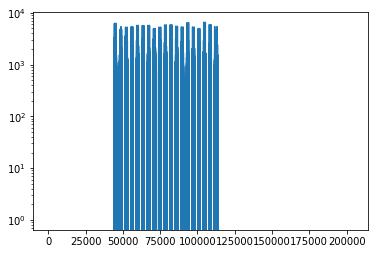

In [78]:
binary = fileToBinary('Data_Files/Holiday.txt')
symbols = qpsk(binary)
symbols = SchmidlCox(symbols)#[:511]
ofdm_symbols, number_of_ofdm_symbols = ofdmSymbols(symbols, min_freq, max_freq, N, K)
x = save_transmit2((Pause(1), ofdm_symbols, Pause(2)), True, location)
logPlot(x)

<ipython-input-76-03489bc60ad8>:120: RuntimeWarning: invalid value encountered in true_divide
  M = abs(P/R)**2
<ipython-input-106-c5c7f1f87b79>:7: RuntimeWarning: invalid value encountered in less_equal
  zeroCrossing = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 100)
<ipython-input-106-c5c7f1f87b79>:7: RuntimeWarning: invalid value encountered in greater
  zeroCrossing = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 100)


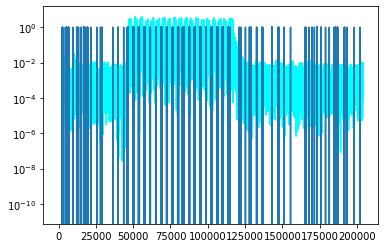

In [106]:
y = audioDataFromFile('recorded_data_' + location + '.wav')
# calculate metric M
M = getM(y, L)
# detect peak of M
M_filt = np.convolve(M, np.ones(K) / K, 'same')
D = np.diff(M_filt)
zeroCrossing = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 100)
plt.yscale('log')
plt.plot(abs(y), color='cyan')
plt.plot(zeroCrossing)

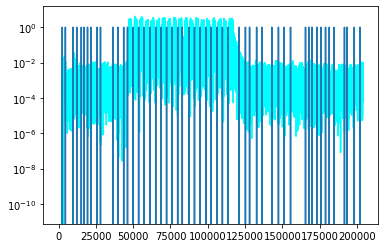

In [107]:
b_ignore = np.ones(1+N+K); b_ignore[0] = 0;  
ignore_times = (scipy.signal.lfilter(b_ignore, (1, ), zeroCrossing) > 0).astype(int)
start = zeroCrossing * (ignore_times == 0)   # keep only the zero-crossings where the ignore-window is not on
plt.yscale('log')
plt.plot(abs(y), color='cyan')
plt.plot(start)